<a href="https://colab.research.google.com/github/mr7495/covid19/blob/master/data_Loading_Training_Evaluating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code on (github.com/mr7495/covid19)

In [1]:
!nvidia-smi #show the allocated GPU

Fri Apr  4 17:00:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Connect your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle


In [10]:
from google.colab import files
files.upload()  # Upload downloaded kaggle.json here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Critical permissions fix[3]


Saving kaggle.json to kaggle.json


In [11]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge


In [12]:
#upgrade and install essential libraries
!pip install keras --upgrade
!pip install zipfile36
!pip install pydicom

In [13]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import pydicom as dicom
import zipfile
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# This is a link to kaggle dataset. If you have downloaded it already, save it as kaggle.zip in the current directory.
# If the link expired, get the new link from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
!wget -cO - 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10338/862042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587124102&Signature=UbIsEpcNjy3ymL%2BCt5cNunBYytcPNlMjVW4RmBKzzuwTL%2BqGHXDzKGbFM3rsewy6nWa9GJgU5ScP%2FVPFUVJdAU3gsqw7aR6En0AqbLMjZ3JE%2BMducSHY94zyZH%2Fn6LqBOwq%2F3FQmK6OC8Ze0OW5oJyNFD7nATMQU7GxbrarIMH6F6zg%2BmL%2BZF%2B6uqlZhAwYpKKLQtzVm7Tyu04Hse0ODtfKV78U3nREvAifK9CzPTRHzAh8AxIdNunMInOn10U4bzxWN%2F5x3Cex7kP6UHsTyJX2XF98eBrQinlgBuyWLbInpQDJVVl1QGFebCa7CN6lnOO2wEeV8Xy5MN6B%2FwlZvEw%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-pneumonia-detection-challenge.zip' > kaggle.zip

--2025-03-16 08:58:21--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10338/862042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587124102&Signature=UbIsEpcNjy3ymL%2BCt5cNunBYytcPNlMjVW4RmBKzzuwTL%2BqGHXDzKGbFM3rsewy6nWa9GJgU5ScP%2FVPFUVJdAU3gsqw7aR6En0AqbLMjZ3JE%2BMducSHY94zyZH%2Fn6LqBOwq%2F3FQmK6OC8Ze0OW5oJyNFD7nATMQU7GxbrarIMH6F6zg%2BmL%2BZF%2B6uqlZhAwYpKKLQtzVm7Tyu04Hse0ODtfKV78U3nREvAifK9CzPTRHzAh8AxIdNunMInOn10U4bzxWN%2F5x3Cex7kP6UHsTyJX2XF98eBrQinlgBuyWLbInpQDJVVl1QGFebCa7CN6lnOO2wEeV8Xy5MN6B%2FwlZvEw%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-pneumonia-detection-challenge.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2025-03-16 08:58:21 ERROR 400: Bad Request.



In [14]:
#Get the zip file I have shared, that contains the covid-chestxray-dataset images until 12 April
# Through the link below get the shared zip file and add it to your drive:
# https://drive.google.com/file/d/1Bwn4vTQUUB0tHK5aHh--Rk6eOxs2jg3q/view?usp=sharing
archive = zipfile.ZipFile('/content/rsna-pneumonia-detection-challenge.zip') #Extract Kaggle Dataset
for file in archive.namelist():
     archive.extract(file, './All')
archive = zipfile.ZipFile('/content/drive/MyDrive/covid19/covid19-master/covid-chestxray-dataset.zip') #Extract covid-chestxray-Dataset
for file in archive.namelist():
     archive.extract(file, './covid-chestxray-dataset')

In [15]:
fold_num=1 #Select Fold Number

In [16]:
try:
  os.mkdir('All/All')
except:
  pass

In [17]:
!git clone https://github.com/mr7495/covid19 #connect to our repository on GitHub

Cloning into 'covid19'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 421 (delta 2), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (421/421), 6.56 MiB | 27.51 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [18]:
#Warning: Our prepared All.csv & train1.csv to train8.csv in each fold, are based on the covid-chestxray-dataset until 12 April.
#If you have used https://drive.google.com/file/d/1Bwn4vTQUUB0tHK5aHh--Rk6eOxs2jg3q/view?usp=sharing link to get the covid-chestxray-dataset.zip file(like the cells above), you can use our prepared csv files
#But if you want to load the updated covid-chestxray-dataset, you must make some changes to the csvfiles.
shutil.copy('covid19/prepared_csv_files/All.csv','All')
for i in range(1,9): #Load the 8 training phases csv files of the indicated fold
  shutil.copy('covid19/prepared_csv_files/fold{}/train{}.csv'.format(fold_num,i),'.')
  globals()['train{}'.format(i)]=[]

# The code for creating All.csv and training.csv files is available on  covid19/dataset preparing.ipynb.

In [19]:
images=[]
for r,d,f in os.walk('All/stage_2_train_images'): #Read the name of the images in both datasets
  for file in f:
    images.append(os.path.join(r,file))
for r,d,f in os.walk('covid-chestxray-dataset/images'):
  for file in f:
   images.append(os.path.join(r,file))

In [20]:
csv_all=pd.read_csv('All/All.csv', nrows=None) #Read the CSV file that contains the names of the images with their labels.
for index, row in csv_all.iterrows(): #This loop reads the images, converts them to suitable format and saves them in the All directory
  if '.png' in row['filename']: #For creating the All.csv we have converted the kaggle dataset images to png format,
                                #but some of the images in the other dataset also are in the format of png, so we use try/except here to distinguish which dataset, the annotation in the CSV file belongs to.
    try:
      png_index=row['filename'].find('.png')
      last_name=row['filename'][:png_index]+'.dcm'
      ds = dicom.dcmread(os.path.join('All/stage_2_train_images',last_name))
      pixel_array_numpy = ds.pixel_array
      imgname = last_name[:-4]+'.png'
      cv2.imwrite(os.path.join('All/All', imgname), pixel_array_numpy)
    except:
      png_index=row['filename'].find('.png')
      img=cv2.imread(os.path.join('covid-chestxray-dataset/images',row['filename'][:png_index+4]))
      gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join('All/All', row['filename'][:png_index+4]), gray)
  else:
    img=cv2.imread(os.path.join('covid-chestxray-dataset/images',row['filename']))
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join('All/All', row['filename']), gray)

In [21]:
All=[] #Thie list that is readed from All.csv
all_train=[] #This list contains the training annotations
all_test=[]
with open('All/All.csv',newline='', mode='r') as csvfile: #Adding All.csv rows to All list
      csvreader = csv.reader(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      for row in csvreader:
          All.append(row)
for i in range(1,9): #Adding training1.csv to training8.csv rows to All_train list. This 1 to 8 indicate the 8 training phases
  with open('train{}.csv'.format(i),newline='', mode='r') as csvfile:
      csvreader = csv.reader(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      for row in csvreader:
        all_train.append(row)
with open('all_test.csv'.format(i),newline='', mode='w') as csvfile: #Add all the other images that do not belong to the training phases, to the test set
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['filename','class'])
    for row in All:
      if row not in all_train:
        csvwriter.writerow(row)

In [ ]:
#Because we have written our code somehow to only save the epochs with the best validation accuracy during the training,
# we created the s_test.csv with 631 images. That is why validating each epoch for 11302 images during training would be terribly time-consuming
#so we select a random s_test.csv for evaluating the network during the training process.

In [22]:
for i in range(10): #Shuffle the All list
  random.shuffle(All)
with open('s_test.csv'.format(i),newline='', mode='w') as csvfile: #Create s_test.csv file for evaluating the network during training
    csvwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['filename','class'])
    ln=0
    lp=0
    for row in All:
      if row not in all_train:
        if row[1]=='COVID-19':
          csvwriter.writerow(row)
        elif row[1]=='normal':
          if ln<300:
            csvwriter.writerow(row)
            ln+=1
        else:
          if lp<300:
            csvwriter.writerow(row)
            lp+=1

In [23]:
#remove the unnecessary file to increase the free space
try:
  os.remove('kaggle.zip')
  shutil.rmtree('All/stage_2_train_images')
  shutil.rmtree('All/stage_2_test_images')
  shutil.rmtree('covid-chestxray-dataset')
except:
  pass

In [24]:
#Here we set the data generators for applying data augmentation methods
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rescale=1./255,zoom_range=0.05,rotation_range=360,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05)
test_datagen = ImageDataGenerator(rescale=1./255)
test_df = pd.read_csv("s_test.csv")

In [ ]:
# Now our data is ready
# We create the neural network in the next level
#If you want to use our trained network you can visit this shared folde:
#  https://drive.google.com/drive/folders/19R4T-D-bWUkQOh3xy5CkIDAmkLBt8ID7?usp=sharing

In [ ]:
import keras.backend as k
k.clear_session() #Clear keras backend
try:
  os.mkdir('models')
except:
  pass
full_name='concatenate'
classes_number=3 #Number of classes
input_tensor=Input(shape=(300,300,3))
######################################################################################################
base_model1 = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
features1 = base_model1.output
######################################################################################################
base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
features2 = base_model2.output
concatenated=keras.layers.concatenate([features1,features2]) #Concatenate the extracted features
####################################################################################################
conv=keras.layers.Conv2D(1024, (1, 1),padding='same')(concatenated) #add the concatenated features to a convolutional layer
feature = Flatten(name='flatten')(conv)
dp = Dropout(0.5)(feature) #add dropout
preds = Dense(classes_number, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp)
Concatenated_model = Model(inputs=input_tensor, outputs=preds)
#######################################################
for layer in Concatenated_model.layers:
  layer.trainable = True
Concatenated_model.compile(optimizer=optimizers.Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
filepath="models/%s-{epoch:02d}-{val_accuracy:.4f}.keras"%full_name # Changed .hdf5 to .keras
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [checkpoint]

for epoch_num in range(1,9): # This loop applies the 8 phases for training
  train_df =pd.read_csv("train{}.csv".format(epoch_num)) #Add data generators for parsing images to the network while training
  train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='All/All',
        x_col="filename",
        y_col="class",
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical',shuffle=True)
  validation_generator = test_datagen.flow_from_dataframe(
          dataframe=test_df,
          directory='All/All',
          x_col="filename",
          y_col="class",
          target_size=(300, 300),
          batch_size=32,
          class_mode='categorical',shuffle=True)
Concatenated_model.fit(train_generator, epochs=100,validation_data=validation_generator,shuffle=True,callbacks=callbacks_list) #start training



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 633 validated image filenames belonging to 3 classes.
Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - accuracy: 0.5079 - loss: 0.9994 - precision: 0.5557 - recall: 0.3848 - val_accuracy: 0.7813 - val_loss: 0.5691 - val_precision: 0.7959 - val_recall: 0.7417
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7839 - loss: 0.5915 - precision: 0.8003 - recall: 0.7648 - val_accuracy: 0.6783 - val_loss: 0.9924 - val_precision: 0.6789 - val_recall: 0.6735
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7577 - loss: 0.6186 - precision: 0.7798 - recall: 0.7485 - val_accuracy: 0.7940 - val_loss: 0.5280 - val_precision: 0.7990 - val_recall: 0.7876
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7905 - loss: 0.5240 - precision: 0.7960 - recall: 0.7714 - val_accuracy: 0.8288 - val_loss: 0.4548 - val_precision: 0.8331 - val_recall: 0.8225
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8470 - loss: 0.3800 - precision: 0.8513 - recall: 0.8395 - val_accuracy: 0.6941 - val_loss: 0

KeyboardInterrupt: 

In [ ]:
import keras.backend as k
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

k.clear_session()
try:
  os.mkdir('models')
except:
  pass

full_name='concatenate'
classes_number=3
input_tensor=Input(shape=(300,300,3))

# Model architecture (unchanged)
base_model1 = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)

concatenated=keras.layers.concatenate([base_model1.output, base_model2.output])
conv=keras.layers.Conv2D(1024, (1, 1), padding='same')(concatenated)
feature = Flatten(name='flatten')(conv)
dp = Dropout(0.5)(feature)
preds = Dense(classes_number, activation='softmax',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp)
Concatenated_model = Model(inputs=input_tensor, outputs=preds)

# Compile with initial learning rate
for layer in Concatenated_model.layers:
  layer.trainable = True
Concatenated_model.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy', Precision(), Recall()])

# Enhanced callbacks configuration
filepath="/content/models/%s-{epoch:02d}-{val_accuracy:.4f}.keras"%full_name
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,       # Reduce LR by 50% when plateau
    patience=5,       # Wait 5 epochs before reducing
    verbose=1,
    mode='max',
    min_lr=1e-7       # Minimum learning rate
)

callbacks_list = [checkpoint, early_stopping, lr_scheduler]

for epoch_num in range(1,9):
    train_df = pd.read_csv("train{}.csv".format(epoch_num))

    # Calculate class weights for this specific training set
    class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
    class_weight_dict = dict(enumerate(class_weights))

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='All/All',
        x_col="filename",
        y_col="class",
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

    validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='All/All',
        x_col="filename",
        y_col="class",
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

    Concatenated_model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        shuffle=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Add class weights here
    )



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Found 633 validated image filenames belonging to 3 classes.
Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.5168 - loss: 1.0221 - precision: 0.5360 - recall: 0.3383 - val_accuracy: 0.7559 - val_loss: 0.5526 - val_precision: 0.7630 - val_recall: 0.7448 - learning_rate: 1.0000e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7659 - loss: 0.6268 - precision: 0.7797 - recall: 0.7531 - val_accuracy: 0.7528 - val_loss: 0.7535 - val_precision: 0.7581 - val_recall: 0.7448 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7991 - loss: 0.5673 - precision: 0.8106 - recall: 0.7855 - val_accuracy: 0.8193 - val_loss: 0.5307 - val_precision: 0.8230 - val_recall: 0.8177 - learning_rate: 1.0000e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8416 - loss: 0.4320 - precision: 0.8483 - recall: 0.8264 - val_accuracy: 0.8225 - val_loss: 0.5205 - val_precision: 0.8251 - val_recall: 0.8225 - learning_rate: 1.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8351 - loss: 0.4852 - precision: 0.8464 - recall: 0.8323 - val_accuracy: 0.8431 - val_loss: 0.4363 - val_precision: 0.8442 - val_recall: 0.8415 - learning_rate: 2.5000e-05
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8580 - loss: 0.3803 - precision: 0.8703 - recall: 0.8526 - val_accuracy: 0.8067 - val_loss: 0.4671 - val_precision: 0.8131 - val_recall: 0.8067 - learning_rate: 2.5000e-05
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8758 - loss: 0.3541 - precision: 0.8852 - recall: 0.8683 - val_accuracy: 0.7607 - val_loss: 0.5486 - val_precision: 0.7615 - val_recall: 0.7591 - learning_rate: 2.5000e-05
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8709 - loss: 0.3197 - precision: 0.8744 - recall: 0.8555 - val_accuracy: 0.8542 - val_loss: 0.3946 - val_precision: 0.8562 - val_recall: 0.8494 - learning_rate: 2.5000e-05
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9227 - loss: 0.2276 - precision: 0.9238 - recall: 0.9133 - val_accuracy: 0.8922 - val_loss: 0.2824 - val_precision: 0.8949 - val_recall: 0.8906 - learning_rate: 7.8125e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9058 - loss: 0.2263 - precision: 0.9087 - recall: 0.9048 - val_accuracy: 0.8906 - val_loss: 0.2850 - val_precision: 0.8933 - val_recall: 0.8891 - learning_rate: 7.8125e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9361 - loss: 0.1579 - precision: 0.9412 - recall: 0.9340 - val_accuracy: 0.8906 - val_loss: 0.2852 - val_precision: 0.8933 - val_recall: 0.8891 - learning_rate: 7.8125e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9224 - loss: 0.2066 - precision: 0.9224 - recall: 0.9168 - val_accuracy: 0.8922 - val_loss: 0.2853 - val_precision: 0.8949 - val_recall: 0.8906 - learning_rate: 7.8125e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8972 - loss: 0.2838 - precision: 0.8989 - recall: 0.8964 - val_accuracy: 0.8922 - val_loss: 0.2852 - val_precision: 0.8946 - val_recall: 0.8875 - learning_rate: 1.9531e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9176 - loss: 0.1818 - precision: 0.9177 - recall: 0.9161 - val_accuracy: 0.8891 - val_loss: 0.2846 - val_precision: 0.8930 - val_recall: 0.8859 - learning_rate: 1.9531e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9028 - loss: 0.2342 - precision: 0.9045 - recall: 0.8985 - val_accuracy: 0.8875 - val_loss: 0.2839 - val_precision: 0.8901 - val_recall: 0.8859 - learning_rate: 1.9531e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9293 - loss: 0.2029 - precision: 0.9296 - recall: 0.9243 - val_accuracy: 0.8891 - val_loss: 0.2841 - val_precision: 0.8917 - val_recall: 0.8875 - learning_rate: 1.9531e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8984 - loss: 0.2085 - precision: 0.9000 - recall: 0.8936 - val_accuracy: 0.8891 - val_loss: 0.2845 - val_precision: 0.8915 - val_recall: 0.8859 - learning_rate: 1.0000e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8996 - loss: 0.2611 - precision: 0.9004 - recall: 0.8970 - val_accuracy: 0.8859 - val_loss: 0.2836 - val_precision: 0.8884 - val_recall: 0.8827 - learning_rate: 1.0000e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9256 - loss: 0.1797 - precision: 0.9358 - recall: 0.9245 - val_accuracy: 0.8859 - val_loss: 0.2839 - val_precision: 0.8884 - val_recall: 0.8827 - learning_rate: 1.0000e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8970 - loss: 0.2229 - precision: 0.8995 - recall: 0.8921 - val_accuracy: 0.8859 - val_loss: 0.2835 - val_precision: 0.8912 - val_recall: 0.8827 - learning_rate: 1.0000e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9180 - loss: 0.2024 - precision: 0.9190 - recall: 0.9172 - val_accuracy: 0.8891 - val_loss: 0.2807 - val_precision: 0.8930 - val_recall: 0.8859 - learning_rate: 1.0000e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9092 - loss: 0.2231 - precision: 0.9118 - recall: 0.9084 - val_accuracy: 0.8906 - val_loss: 0.2824 - val_precision: 0.8960 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9103 - loss: 0.2090 - precision: 0.9191 - recall: 0.9029 - val_accuracy: 0.8906 - val_loss: 0.2815 - val_precision: 0.8962 - val_recall: 0.8891 - learning_rate: 1.0000e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9041 - loss: 0.2258 - precision: 0.9085 - recall: 0.9041 - val_accuracy: 0.8922 - val_loss: 0.2817 - val_precision: 0.8960 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9092 - loss: 0.2283 - precision: 0.9229 - recall: 0.9062 - val_accuracy: 0.8922 - val_loss: 0.2807 - val_precision: 0.8963 - val_recall: 0.8906 - learning_rate: 1.0000e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9034 - loss: 0.2494 - precision: 0.9047 - recall: 0.8977 - val_accuracy: 0.8922 - val_loss: 0.2803 - val_precision: 0.8960 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8984 - loss: 0.2427 - precision: 0.8987 - recall: 0.8890 - val_accuracy: 0.8906 - val_loss: 0.2800 - val_precision: 0.8960 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9215 - loss: 0.1933 - precision: 0.9215 - recall: 0.9210 - val_accuracy: 0.8891 - val_loss: 0.2795 - val_precision: 0.8946 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9123 - loss: 0.2099 - precision: 0.9132 - recall: 0.9074 - val_accuracy: 0.8922 - val_loss: 0.2805 - val_precision: 0.8960 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8934 - loss: 0.2440 - precision: 0.8989 - recall: 0.8922 - val_accuracy: 0.8906 - val_loss: 0.2816 - val_precision: 0.8947 - val_recall: 0.8891 - learning_rate: 1.0000e-07
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9008 - loss: 0.2187 - precision: 0.9028 - recall: 0.9008 - val_accuracy: 0.8922 - val_loss: 0.2822 - val_precision: 0.8963 - val_recall: 0.8906 - learning_rate: 1.0000e-07
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9088 - loss: 0.2765 - precision: 0.9088 - recall: 0.9085 - val_accuracy: 0.8891 - val_loss: 0.2828 - val_precision: 0.8946 - val_recall: 0.8875 - learning_rate: 1.0000e-07
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step -

In [ ]:
import gc
import torch
import tensorflow as tf # Import TensorFlow
gc.collect()  # invoke Python garbage collector
torch.cuda.empty_cache()  # clear CUDA memory
tf.keras.backend.clear_session()  # Reset before each model
del Concatenated_model  # Remove Python references


NameError: name 'Concatenated_model' is not defined

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# After training multiple models
trained_models = []
for r,d,f in os.walk('/content/models'):
    for file in f:
        trained_models.append(keras.models.load_model(os.path.join(r, file)))

# Generate meta-features
def get_meta_features(models, generator):
    return np.hstack([model.predict(generator, verbose=0) for model in models])



In [ ]:
import numpy as np
import pandas as pd

# Initialize lists to store aggregated features and labels
X_meta_train = []
y_meta_train = []

# Loop through each phase (epoch_num in range(1,9)) to collect data
for epoch_num in range(1,9):
    # Load training data for the current epoch
    train_df = pd.read_csv(f"train{epoch_num}.csv")

    # Create data generator for the current epoch
    train_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='All/All',
        x_col="filename",
        y_col="class",
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    # Generate meta-features using base models for the current epoch
    X_meta_epoch = get_meta_features(trained_models, train_generator)

    # Collect true labels for the current epoch
    y_meta_epoch = train_generator.classes

    # Append features and labels to the aggregated lists
    X_meta_train.append(X_meta_epoch)
    y_meta_train.append(y_meta_epoch)

# Concatenate features and labels from all epochs into single arrays
X_meta_train = np.vstack(X_meta_train)
y_meta_train = np.concatenate(y_meta_train)


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
import numpy as np

# Save feature matrix and labels
# np.save('/content/drive/MyDrive/covid19/covid19-master/X_meta_train.npy', X_meta_train)  # Save feature matrix
# np.save('/content/drive/MyDrive/covid19/covid19-master/y_meta_train.npy', y_meta_train)  # Save labels

# Load feature matrix and labels
X_meta_train = np.load('/content/drive/MyDrive/covid19/covid19-master/X_meta_train.npy')  # Load feature matrix
y_meta_train = np.load('/content/drive/MyDrive/covid19/covid19-master/y_meta_train.npy')  # Load labels



In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on label distribution
classes = np.unique(y_meta_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_meta_train)

# Create sample weights for each instance based on its class weight
sample_weights = np.array([class_weights[y] for y in y_meta_train])


In [ ]:
import xgboost as xgb

# Configure XGBoost meta-model with appropriate hyperparameters
meta_model = xgb.XGBClassifier(
    objective='multi:softprob',
    max_depth=8,
    learning_rate=0.0001,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
)

# Train meta-model using aggregated features, labels, and sample weights
meta_model.fit(X_meta_train, y_meta_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Saving
import joblib
# joblib.dump(meta_model, '/content/drive/MyDrive/covid19/covid19-master/models/covid19_meta_model.joblib')

# Loading (Correct Method)
loaded_model = joblib.load('/content/drive/MyDrive/covid19/covid19-master/models/covid19_meta_model.joblib')  # No XGBClassifier() init needed


In [ ]:
# Keep validation generator with shuffle=True since we're evaluating (not training)
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='All/All',
    x_col="filename",
    y_col="class",
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Preserve shuffle for real-world simulation
)
X_meta = get_meta_features(trained_models, validation_generator)
y_meta = validation_generator.classes
# Generate predictions and probabilities


Found 631 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


              precision    recall  f1-score   support

       COVID       0.91      1.00      0.95       248
      Normal       0.94      0.97      0.95      2400
   Pneumonia       0.97      0.93      0.95      2400

    accuracy                           0.95      5048
   macro avg       0.94      0.97      0.95      5048
weighted avg       0.95      0.95      0.95      5048



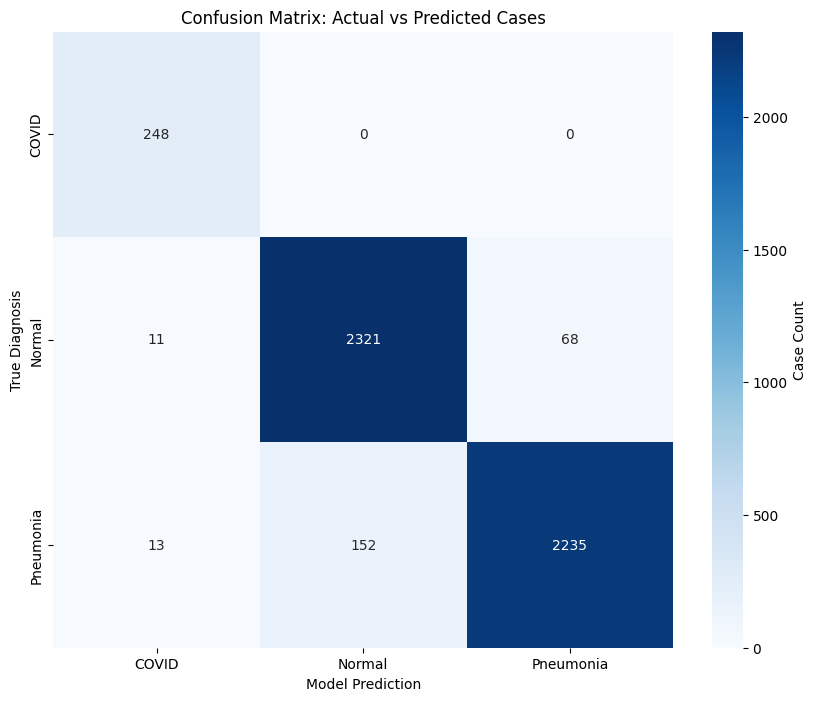

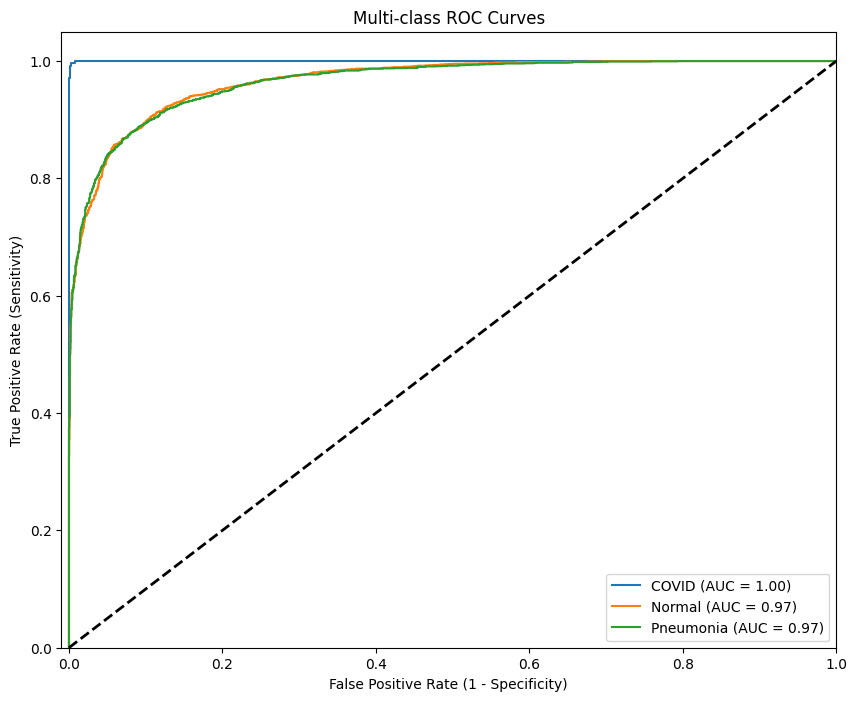

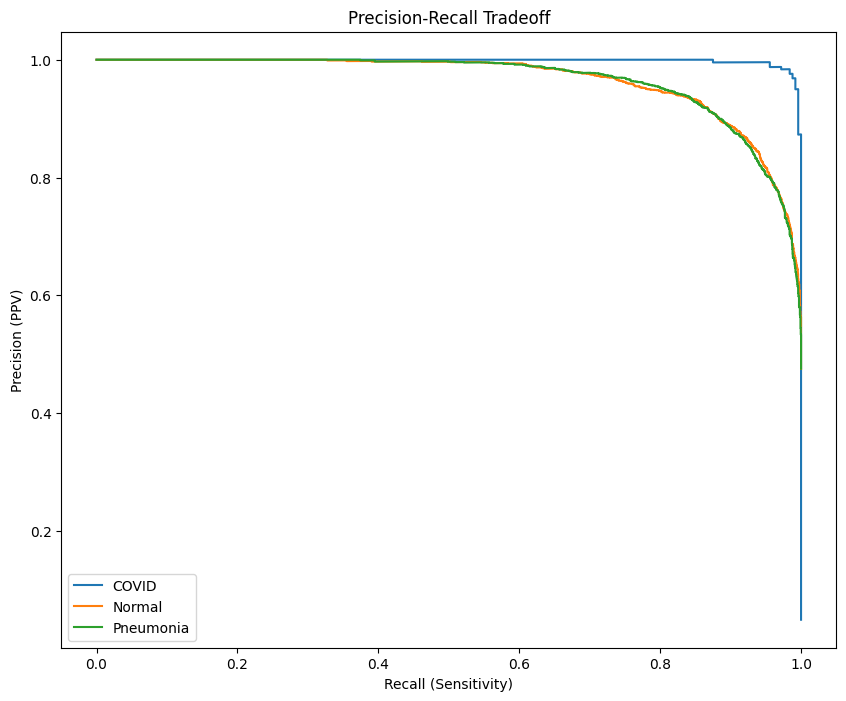

In [ ]:
y_pred = meta_model.predict(X_meta_train)
y_pred_probs = meta_model.predict_proba(X_meta_train)  # Get class probabilities
class_names=['COVID', 'Normal', 'Pneumonia']
# 1. Classification Report
print(classification_report(y_meta_train, y_pred,
                          target_names=class_names))

# 2. Enhanced Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_meta_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Case Count'})
plt.title('Confusion Matrix: Actual vs Predicted Cases')
plt.ylabel('True Diagnosis')
plt.xlabel('Model Prediction')
plt.show()

# 3. Multi-class ROC Curve
plt.figure(figsize=(10,8))
for i, class_name in enumerate(class_names):
    # Convert y_meta to binary labels for the current class
    binary_y_true = [1 if x == i else 0 for x in y_meta_train]  # Changed to list comprehension
    fpr, tpr, _ = roc_curve(binary_y_true, y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.show()

# 4. Precision-Recall Curve
plt.figure(figsize=(10,8))
for i, class_name in enumerate(class_names):
    binary_y_true = np.array(y_meta_train) == i  # Convert to NumPy array and do element-wise comparison
    precision, recall, _ = precision_recall_curve(binary_y_true, y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{class_name}')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Precision-Recall Tradeoff')
plt.legend(loc="best")
plt.show()


In [ ]:
#After the training is done, we attempt to evaluate our saved networks.

In [ ]:
trained_models=[]
for r,d,f in os.walk('/content/drive/MyDrive/covid19/covid19-master/models'):
  for file in f:
    trained_models.append(os.path.join(r,file)) #Add the saved models in the models directory
reports={}
test_df = pd.read_csv("all_test.csv") #Load the full test CSV file that includes 11302 images
validation_generator = test_datagen.flow_from_dataframe( #Set new data generator
        dataframe=test_df,
        directory='All/All',
        x_col="filename",
        y_col="class",
        target_size=(300, 300),
        batch_size=20,
        class_mode='categorical',shuffle=True)
for trained_model in trained_models:
  k.clear_session()
  net=keras.models.load_model(trained_model) #load model
  covid_label= validation_generator.class_indices['COVID-19'] #get the index of COVUD-19 class
  pneu_label= validation_generator.class_indices['pneumonia'] #get the index of pneumonia class
  normal_label= validation_generator.class_indices['normal']  #get the index of normal class
  tp=0 #True Positives
  fp=0 #False Positives
  anum=0 #All the images numbers
  ###########
  wrong_covid=0
  correct_covid=0
  not_detected_covid=0
  covid_num=0
  ###########
  wrong_pneu=0
  correct_pneu=0
  not_detected_pneu=0
  pneu_num=0
  ############
  wrong_normal=0
  correct_normal=0
  not_detected_normal=0
  normal_num=0
  ##############
  wrong_covid_normal=0 #COVID-19 class which has been detected as normal, incorrectly
  wrong_covid_pneu=0   #COVID-19 class which has been detected as pneumonia, incorrectly
  wrong_pneu_covid=0   #pneumonia class which has been detected as COVID-19 , incorrectly
  wrong_pneu_normal=0  #pneumonia class which has been detected as normal , incorrectly
  wrong_normal_pneu=0  #normal class which has been detected as pneumonia , incorrectly
  wrong_normal_covid=0  #normal class which has been detected as COVID-19 , incorrectly
  ################
  for num,img_name in enumerate(validation_generator.filenames): #load image
    gt_ind=validation_generator.classes[num] #get the loaded image class index
    img=cv2.resize(cv2.imread(os.path.join('All','All',img_name)),(300,300)) #resize image
    img=img.astype('float32') / 255.0 #scale the image
    pred_ind=np.argmax(net.predict(np.expand_dims(img,axis=0))[0]) #get the predicted class index

    anum+=1 #count the number of images


    if gt_ind==covid_label:
      covid_num+=1
    if gt_ind==pneu_label:
      pneu_num+=1
    if gt_ind==normal_label:
      normal_num+=1
    ##################
    if gt_ind==covid_label and pred_ind==covid_label:
      correct_covid+=1
    if gt_ind==covid_label and pred_ind!=covid_label:
      not_detected_covid+=1
      if pred_ind==pneu_label:
        wrong_covid_pneu+=1
      elif pred_ind==normal_label:
        wrong_covid_normal+=1
    if gt_ind!=covid_label and pred_ind==covid_label:
      wrong_covid+=1
    ###########################################
    if gt_ind==normal_label and pred_ind==normal_label:
      correct_normal+=1
    if gt_ind==normal_label and pred_ind!=normal_label:
      not_detected_normal+=1
      if pred_ind==pneu_label:
        wrong_normal_pneu+=1
      elif pred_ind==covid_label:
        wrong_normal_covid+=1
    if gt_ind!=normal_label and pred_ind==normal_label:
      wrong_normal+=1
    ###########################################
    if gt_ind==pneu_label and pred_ind==pneu_label:
      correct_pneu+=1
    if gt_ind==pneu_label and pred_ind!=pneu_label:
      not_detected_pneu+=1
      if pred_ind==normal_label:
        wrong_pneu_normal+=1
      elif pred_ind==covid_label:
        wrong_pneu_covid+=1
    if gt_ind!=pneu_label and pred_ind==pneu_label:
      wrong_pneu+=1
    ###########################################

    if pred_ind==gt_ind:
      tp+=1
    else:
      fp+=1

  reports[trained_model[7:]]=[correct_covid,wrong_covid,not_detected_covid,
                   correct_pneu,wrong_pneu,not_detected_pneu,
                   correct_normal,wrong_normal,not_detected_normal,
                   covid_num,pneu_num,normal_num,tp,fp,wrong_covid_normal,wrong_covid_pneu,
                   wrong_pneu_covid,wrong_pneu_normal,wrong_normal_pneu,wrong_normal_covid]


  print(trained_model[7:])
  print('correct_covid: ',correct_covid/covid_num,'%')
  print('wrong_covid: ',wrong_covid)
  print('not_detected_covid: ',not_detected_covid/covid_num,'%')
  print('###########################')

  with open('{}-fold{}.csv'.format(trained_model[7:],fold_num),newline='', mode='w') as csvfile: #save the evaluation data into csvfile
      csv_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      csv_writer.writerow(['name','correct_covid','wrong_covid','not_detected_covid',
                            'correct_pneu','wrong_pneu','not_detected_pneu',
                            'correct_normal','wrong_normal','not_detected_normal',
                            'covid_num','pneu_num','normal_num','tp','fp','wrong_covid_normal','wrong_covid_pneu',
                    'wrong_pneu_covid','wrong_pneu_normal','wrong_normal_pneu','wrong_normal_covid'])
      for key in reports.keys():
          row=[key]
          row.extend(reports[key])

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

FileNotFoundError: [Errno 2] No such file or directory: 't/drive/MyDrive/covid19/covid19-master/models/concatenate-01-0.6292.keras-fold1.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
array=[['wrong_covid_normal','wrong_covid_pneu','correct_covid'],
       ['wrong_pneu_normal','correct_pneu','wrong_pneu_covid'],
       ['correct_normal','wrong_normal_pneu','wrong_normal_covid']]
results={1:{},2:{},3:{},4:{},5:{}}
for fo in range(1,6):
    report=pd.read_excel('results/selected_fold{}.xlsx'.format(fo))
    data={}
    for index,item in report.iterrows():
        images_num=item['tp']+item['fp']
        data[item['name']]=[[],[],[]]
        acc=item['tp']/(item['tp']+item['fp'])
        covid_recall=item['correct_covid']/item['covid_num']
        covid_Specificity=(images_num-item['covid_num']-item['wrong_covid'])/(images_num-item['covid_num']-item['wrong_covid']+item['wrong_covid'])
        covid_accuracy=(images_num-item['covid_num']-item['wrong_covid']+item['correct_covid'])/(images_num-item['covid_num']-item['wrong_covid']+item['correct_covid']+item['wrong_covid']+item['not_detected_covid'])

        pneu_recall=item['correct_pneu']/item['pneu_num']
        pneu_Specificity=(images_num-item['pneu_num']-item['wrong_pneu'])/(images_num-item['pneu_num']-item['wrong_pneu']+item['wrong_pneu'])
        pneu_accuracy=(images_num-item['pneu_num']-item['wrong_pneu']+item['correct_pneu'])/(images_num-item['pneu_num']-item['wrong_pneu']+item['correct_pneu']+item['wrong_pneu']+item['not_detected_pneu'])

        normal_recall=item['correct_normal']/item['normal_num']
        normal_Specificity=(images_num-item['normal_num']-item['wrong_normal'])/(images_num-item['normal_num']-item['wrong_normal']+item['wrong_normal'])
        normal_accuracy=(images_num-item['normal_num']-item['wrong_normal']+item['correct_normal'])/(images_num-item['normal_num']-item['wrong_normal']+item['correct_normal']+item['wrong_normal']+item['not_detected_normal'])

        results[fo][item['name']]={'acc':acc,'covid_recall':covid_recall,'covid_Specificity':covid_Specificity,
                               'covid_accuracy':covid_accuracy,'pneu_recall':pneu_recall,'pneu_Specificity':pneu_Specificity,
                               'pneu_accuracy':pneu_accuracy,
                               'normal_recall':normal_recall,'normal_Specificity':normal_Specificity,
                               'normal_accuracy':normal_accuracy}
        for nn,aa in enumerate(array):
            for a in aa:
                data[item['name']][nn].append(item[a])


    for key in data:
        gt = ['NORMAL','PNEUMONIA','COVID-19']
        preds = ["COVID-19", "PNEUMONIA", "NORMAL",]
        fig, ax = plt.subplots()
        im = ax.imshow(np.array(data[key]), interpolation='nearest', cmap=plt.cm.Blues)
        index=key.find('-')
        if 'concatenat' in key:
            ax.set(xticks=np.arange(np.array(data[key]).shape[1]),
               yticks=np.arange(np.array(data[key]).shape[0]),
               # ... and label them with the respective list entries
               xticklabels=gt, yticklabels=preds,
               title='Confusion Matrix for the concatenated network-fold{}'.format(fo),
               ylabel='Ground Truth Label',
               xlabel='Predicted Label')
        else:
            ax.set(xticks=np.arange(np.array(data[key]).shape[1]),
               yticks=np.arange(np.array(data[key]).shape[0]),
               # ... and label them with the respective list entries
               xticklabels=gt, yticklabels=preds,
               title='Confusion Matrix for {}-fold{}'.format(key[:index],fo),
               ylabel='Ground Truth Label',
               xlabel='Predicted Label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

        fmt = '.2f'
        thresh = 1000000.
        # Loop over data dimensions and create text annotations.
        for i in range(len(gt)):
            for j in range(len(preds)):
                    ax.text(j, i, format(np.array(data[key])[i, j]),
                            ha="center", va="center",
                            color="white" if np.array(data[key])[i, j] > thresh else "black")
        fig.tight_layout()

        #plt.show()
        dash=key.find('-')
        plt.savefig('{}-fold{}-confusion_matrix.pdf'.format(key[:dash],fo))

results['Full']={'Xception':{}, 'concatenate':{},'ResNet50V2':{}}
results['average']={'Xception':{}, 'concatenate':{},'ResNet50V2':{}}
nets=['Xception','ResNet50V2','concatenate']
for net in nets:
    for fokey in results:
        for netkey in results[fokey]:
            if net in netkey:
                for param in results[fokey][netkey]:
                    if param not in results['Full'][net]:
                        results['Full'][net][param]=[]
                    results['Full'][net][param].append(results[fokey][netkey][param])


for net in results['Full']:
    for param in results['Full'][net]:
        results['average'][net][param]=np.average(results['Full'][net][param][:-1])

temp_data=[]
for fo in [1,2,3,4,5,'average']:
    for net in results[fo]:
        if 'Xception' in net:
            temp_data.append([results[fo][net]['covid_Specificity'],
                              results[fo][net]['pneu_Specificity'],
                              results[fo][net]['normal_Specificity'],
                              results[fo][net]['covid_accuracy'],
                              results[fo][net]['pneu_accuracy'],
                              results[fo][net]['normal_accuracy']])
    for net in results[fo]:
        if 'ResNet' in net:
            temp_data.append([results[fo][net]['covid_Specificity'],
                              results[fo][net]['pneu_Specificity'],
                              results[fo][net]['normal_Specificity'],
                              results[fo][net]['covid_accuracy'],
                              results[fo][net]['pneu_accuracy'],
                              results[fo][net]['normal_accuracy']])
    for net in results[fo]:
        if 'oncatenat' in net:
            temp_data.append([results[fo][net]['covid_Specificity'],
                              results[fo][net]['pneu_Specificity'],
                              results[fo][net]['normal_Specificity'],
                              results[fo][net]['covid_accuracy'],
                              results[fo][net]['pneu_accuracy'],
                              results[fo][net]['normal_accuracy']])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve,
                             RocCurveDisplay, PrecisionRecallDisplay)
import os
import csv
from keras.models import load_model

# Create report directory structure
os.makedirs('/content/drive/MyDrive/covid19/covid19-master/reports/visualizations', exist_ok=True)
os.makedirs('/content/drive/MyDrive/covid19/covid19-master/reports/classification_reports', exist_ok=True)

trained_models = []
for r,d,f in os.walk('/content/models'):
    for file in f:
        trained_models.append(os.path.join(r,file))

test_df = pd.read_csv("all_test.csv")
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='All/All',
    x_col="filename",
    y_col="class",
    target_size=(300, 300),
    batch_size=20,
    class_mode='categorical',
    shuffle=False  # Important for consistent ordering
)

class_names = list(validation_generator.class_indices.keys())

for model_path in trained_models:
    model_name = os.path.basename(model_path).split('.')[0]
    model_dir = f'/content/drive/MyDrive/covid19/covid19-master/reports/visualizations/{model_name}'
    os.makedirs(model_dir, exist_ok=True)

    # Load model
    model = load_model(model_path)

    # Generate predictions
    y_true = validation_generator.classes
    y_pred_probs = model.predict(validation_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_dir}/confusion_matrix.png')
    plt.close()

    # ROC Curve
    plt.figure(figsize=(10,8))
    for i in range(len(class_names)):
        # Convert y_true to a binary array for the current class
        binary_y_true = np.array([(val == i) for val in y_true]).astype(int)  # Convert to NumPy array
        fpr, tpr, _ = roc_curve(binary_y_true, y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_dir}/roc_curve.png')
    plt.close()

    # Precision-Recall Curve
    plt.figure(figsize=(10,8))
    for i in range(len(class_names)):
        # Convert y_true to a binary array for the current class using NumPy
        binary_y_true = np.array(y_true) == i
        precision, recall, _ = precision_recall_curve(binary_y_true, y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="best")
    plt.savefig(f'{model_dir}/precision_recall_curve.png')
    plt.close()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'/content/drive/MyDrive/covid19/covid19-master/reports/classification_reports/{model_name}_report.csv')

    # Print summary
    print(f'\n{"="*40}')
    print(f'Evaluation Report for {model_name}')
    print(f'{"="*40}\n')
    print(pd.DataFrame(report).transpose())
    print(f'\nReports saved to: {model_dir}')

print('\nAll evaluations completed!')


Found 11302 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


566/566 ━━━━━━━━━━━━━━━━━━━━ 156s 248ms/step

Evaluation Report for concatenate-29-0

              precision    recall  f1-score      support
COVID-19       0.201923  0.677419  0.311111     31.00000
normal         0.939735  0.901328  0.920131   6851.00000
pneumonia      0.857575  0.897738  0.877197   4420.00000
accuracy       0.899310  0.899310  0.899310      0.89931
macro avg      0.666411  0.825495  0.702813  11302.00000
weighted avg   0.905580  0.899310  0.901670  11302.00000

Reports saved to: /content/drive/MyDrive/covid19/covid19-master/reports/visualizations/concatenate-29-0
566/566 ━━━━━━━━━━━━━━━━━━━━ 144s 243ms/step

Evaluation Report for concatenate-01-0

              precision    recall  f1-score       support
COVID-19       0.666667  0.064516  0.117647     31.000000
normal         0.902669  0.740476  0.813567   6851.000000
pneumonia      0.683395  0.878054  0.768591   4420.000000
accuracy       0.792426  0.792426  0.792426      0.792426
macro avg      0.750910  0.561015 

In [ ]:
!pip install streamlit

In [ ]:
# ngrok http 11434 --response-header-add "Access-Control-Allow-Origin: *" --host-header rewrite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [26]:
%%writefile app.py
import streamlit as st
st.set_page_config(layout="wide")  # Use full-width layout
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
from keras.optimizers import Nadam
import base64
from io import BytesIO
import requests
import re
import json
import cv2

# Custom Nadam Optimizer to load the model
class CustomNadam(Nadam):
    def __init__(self, schedule_decay=0.004, **kwargs):
        kwargs.pop('schedule_decay', None)
        super().__init__(**kwargs)

    @classmethod
    def from_config(cls, config):
        config.pop('schedule_decay', None)
        return super().from_config(config)

# Load trained model
loaded_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/covid19/covid19-master/concatenate-fold1.hdf5',
    compile=False,
    custom_objects={'Nadam': CustomNadam}
)
loaded_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
                     loss='categorical_crossentropy')
print(loaded_model.input)

def preprocess_image(image):
    image = image.resize((300, 300)).convert('RGB')
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Generate Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)  # Ensure training=False
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Overlay Grad-CAM heatmap on original image
def overlay_heatmap(heatmap, original_image):
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

    # Convert PIL image to NumPy array
    original_array = np.array(original_image)

    # Ensure original image has 3 channels (RGB)
    if original_array.shape[-1] == 4:  # If RGBA, convert to RGB
        original_array = cv2.cvtColor(original_array, cv2.COLOR_RGBA2RGB)
    elif len(original_array.shape) == 2:  # If grayscale, convert to 3-channel
        original_array = cv2.cvtColor(original_array, cv2.COLOR_GRAY2RGB)

    # Ensure both images have the same shape
    if original_array.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (original_array.shape[1], original_array.shape[0]))

    # Perform weighted sum
    superimposed_img = cv2.addWeighted(original_array, 0.6, heatmap, 0.4, 0)

    return Image.fromarray(superimposed_img)


def image_to_base64(image):
    """Convert a PIL image to a Base64-encoded string with the correct format."""
    buffered = BytesIO()

    # Detect format based on the mode of the image
    format = "PNG" if image.format is None else image.format

    image.save(buffered, format=format)  # Save with the correct format
    return base64.b64encode(buffered.getvalue()).decode(), format.lower()

def get_health_advice(predicted_class, user_input):
    prompt = f"""
    As a healthcare assistant, provide a detailed step-by-step home care guide for a patient diagnosed with {predicted_class}.
    1. Food intake: What should they eat, and what should they avoid?
    2. Home care: How should they manage symptoms at home?
    3. Precautions: What measures should they take to prevent worsening or spreading the illness?

    User query (if any): {user_input}
    """
    response = requests.post(
        "https://6219-103-171-59-82.ngrok-free.app/api/generate",  # Use your actual ngrok URL
        json={"model": "deepseek-r1:1.5b", "prompt": prompt, "stream": False}
    )

    if response.status_code == 200:
        try:
            response_json = response.json()  # Parse JSON response
            raw_text = response_json.get("response", "")  # Extract the response field

            print("Raw Response:", raw_text)  # Debugging

            # Remove <think> section using regex
            cleaned_text = re.sub(r"<think>.*?</think>", "", raw_text, flags=re.DOTALL).strip()
            return cleaned_text if cleaned_text else "No relevant response received."
        except json.JSONDecodeError:
            return "Error: Could not decode API response."
    else:
        return "Error: Unable to fetch advice from DeepSeek."

def is_xray_image(image):
    """Validate whether the uploaded image is a chest X-ray based on grayscale properties and edge features."""
    image_array = np.array(image.convert("L"))  # Convert to grayscale
    mean_intensity = np.mean(image_array)  # Compute mean pixel intensity
    std_intensity = np.std(image_array)  # Compute standard deviation of pixel intensity
    print(mean_intensity, std_intensity)
    # X-rays tend to have a specific grayscale range (not too bright, not too dark)
    if ( mean_intensity > 170 and std_intensity > 70):
        return False  # Likely not an X-ray

    # Apply Canny edge detection
    edges = cv2.Canny(image_array, threshold1=30, threshold2=100)
    edge_density = np.sum(edges) / edges.size  # Calculate edge density (how many edges exist)
    print(edge_density)
    # Chest X-rays have a moderate to high edge density (due to ribs and lung structures)
    if edge_density < 0.02:  # Threshold (can be tuned)
        return False

    return True

st.markdown(
    "<h1 style='text-align: center;'>COVID-19 X-Ray Classification with Grad-CAM</h1>",
    unsafe_allow_html=True
)


col_left, col_right = st.columns([2, 1])

with col_left:
    st.write("Upload an X-ray image to predict and visualize affected areas.")
    uploaded_file = st.file_uploader("Choose an X-ray image", type=["jpg", "jpeg", "png"])
    THRESHOLD = 0.95  # Set the confidence threshold

    if uploaded_file is not None:
        image = Image.open(uploaded_file)

        # Validate if the uploaded image is an X-ray
        if not is_xray_image(image):
            st.error("⚠️ The uploaded image does not appear to be an X-ray. Please upload a valid chest X-ray image.")
        else:
            preprocessed_image = preprocess_image(image)
            prediction = loaded_model.predict(preprocessed_image)
            predicted_prob = np.max(prediction)
            print(predicted_prob) # Get the highest probability
            predicted_class = ["COVID-19", "Pneumonia", "Normal Lung"][np.argmax(prediction)]
            last_conv_layer = "block14_sepconv2"
            heatmap = get_gradcam_heatmap(loaded_model, preprocessed_image, last_conv_layer)
            heatmap_image = overlay_heatmap(heatmap, image)

        # Layout: Original X-ray | Grad-CAM Heatmap | Prediction Card
        col1, col2, col3 = st.columns([1, 1, 1])

        # Define fixed height for images and card
        img_height = "300px"  # Adjust height as needed

        with col1:
            image_base64, img_format = image_to_base64(image)  # Convert to Base64
            st.markdown(
                f"""
                <figure style="margin: 0; padding: 0; text-align: center; display: flex; flex-direction: column; align-items: center;">
                    <img src="data:image/{img_format};base64,{image_base64}" style="height: {img_height}; width: 100%; object-fit: contain;">
                    <figcaption style="font-size: 20px; color: #555;">Original X-ray</figcaption>
                </figure>
                """,
                unsafe_allow_html=True,
            )

        with col2:
            heatmap_base64, heatmap_format = image_to_base64(heatmap_image)  # Convert to Base64
            st.markdown(
                f"""
                <figure style="margin: 0; padding: 0; text-align: center; display: flex; flex-direction: column; align-items: center;">
                    <img src="data:image/{heatmap_format};base64,{heatmap_base64}" style="height: {img_height}; width: 100%; object-fit: contain;">
                    <figcaption style="font-size: 20px; color: #555;">Grad-CAM Heatmap</figcaption>
                </figure>
                """,
                unsafe_allow_html=True,
            )

        with col3:
            color = "red" if predicted_class == "COVID-19" else "yellow" if predicted_class == "Pneumonia" else "green"
            st.markdown(f"""
                <div style="height: 350px; display: flex; align-items: center; justify-content: center; flex-direction: column; padding: 20px; background-color: #f8f9fa; border-radius: 10px; box-shadow: 0px 4px 8px rgba(0,0,0,0.2);">
                    <h2 style="color: #007BFF;">Diagnosis</h2>
                    <img src="https://th.bing.com/th/id/R.bf2b5df519dd639a7d8857e1661f04da?rik=jWnGyGdMSJIe0Q&riu=http%3a%2f%2fwww.pngall.com%2fwp-content%2fuploads%2f2016%2f06%2fBiohazard-Symbol-Free-PNG-Image.png&ehk=z691ECpLAnk2UhVxDOYPgKXqHAPwuYfAYNW%2bUJt%2fyRA%3d&risl=&pid=ImgRaw&r=0" width="80">
                    <h3 style="color: {color};">{predicted_class} Detected</h3>
                    <p style="font-size: 17px; color: #333;">
                        { "Immediate medical attention recommended." if predicted_class == "COVID-19" else
                          "Consult a doctor for further analysis." if predicted_class == "Pneumonia" else
                          "Lungs appear normal. Stay healthy!" }
                    </p>
                </div>
                <br>
            """, unsafe_allow_html=True)
        with st.expander("📊 Model Performance Metrics"):
            st.markdown("### Model Performance Visualizations")

            # Create three equal columns for visualization
            col_viz1, col_viz2, col_viz3 = st.columns(3)

            # Load and display the ROC-AUC Curve
            with col_viz1:
                st.markdown("#### ROC-AUC Curve")
                roc_auc_img = Image.open("/content/drive/MyDrive/covid19/covid19-master/reports/auc roc.png")  # Replace with the correct path
                st.image(roc_auc_img,  use_container_width=True, caption="Receiver Operating Characteristic Curve")

            # Load and display the Confusion Matrix
            with col_viz2:
                st.markdown("#### Confusion Matrix")
                confusion_matrix_img = Image.open("/content/drive/MyDrive/covid19/covid19-master/reports/confusion matrix.png")  # Replace with the correct path
                st.image(confusion_matrix_img,  use_container_width=True, caption="Confusion Matrix")

            # Load and display the Precision-Recall Curve
            with col_viz3:
                st.markdown("#### Precision-Recall Curve")
                pr_curve_img = Image.open("/content/drive/MyDrive/covid19/covid19-master/reports/precesion recall.png")  # Replace with the correct path
                st.image(pr_curve_img,  use_container_width=True, caption="Precision-Recall Curve")

# --- Chatbot (Right) ---
with col_right:
    # Ensure the header is always at the top
    st.header("Health Assistant 💬")
    chat_container = st.container()

    # Initialize chat history
    if "messages" not in st.session_state:
        st.session_state.messages = []

    # Automatically fetch advice based on the predicted class
    if uploaded_file is not None:  # Ensure an image was uploaded
        auto_advice = get_health_advice(predicted_class, "")  # Empty user_input for automatic advice
        st.session_state.messages.append({"role": "assistant", "content": auto_advice})

    # Display previous messages
    with chat_container:
        for message in st.session_state.messages:
            with st.chat_message(message["role"]):
                st.markdown(message["content"])

    # Allow user to ask follow-up questions
    if user_input := st.chat_input("How can I assist you further?"):
        st.chat_message("user").markdown(user_input)
        # Get AI-generated advice based on the user's query
        advice = get_health_advice(predicted_class, user_input)
        with st.chat_message("assistant"):
            st.markdown(advice)
        # Store chat history
        st.session_state.messages.append({"role": "user", "content": user_input})
        st.session_state.messages.append({"role": "assistant", "content": advice})


Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501
# 35.204.201.156



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.204.201.156:8501

⠴Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏your url is: https://mean-hoops-pump.loca.lt
2025-04-04 17:24:43.809509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743787483.833682    6930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743787483.842302    6930 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 17:24:52.853546: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value

In [ ]:
import requests
url = "https://a914-103-171-59-89.ngrok-free.app"
response = requests.post(url, json={"model": "deepseek-r1:1.5b", "prompt": "Test", "stream": False})
print(response.text)

404 page not found


NameError: name 'predicted_prob' is not defined